# Start-sensitivity analysis (MSE vs uncertainty)

This notebook compares **mean performance across starts** (average across permutations) vs **best-start performance** (oracle upper bound) for Plan B runs.

Definitions (per task + policy):
- **Mean across starts**: average score across permutations (each permutation = a start image).
- **Best start**: max score across permutations.
- **Gap**: best - mean.


In [1]:
from pathlib import Path
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

REPO_ROOT = Path('.').resolve()
if not (REPO_ROOT / 'experiments').exists():
    REPO_ROOT = REPO_ROOT.parent
sys.path.insert(0, str(REPO_ROOT))

from experiments.analysis.task_explorer import iter_family_task_dirs


In [2]:
# Config
REPO_ROOT = Path('.').resolve()
if not (REPO_ROOT / 'experiments').exists():
    REPO_ROOT = REPO_ROOT.parent
PROCEDURES = ['random_v_MSE_v2', 'random_vs_uncertainty_v2']
ABLATION = 'pretrained_baseline'
METRIC = 'initial_dice'  # e.g., final_dice, initial_dice
FAMILIES = None  # e.g., ['ACDC', 'BTCV']


In [3]:
def iter_planb_csvs(repo_root, *, procedure, ablation, families=None):
    for family, task_dir, _root_name in iter_family_task_dirs(
        repo_root, procedure=procedure, include_families=families
    ):
        abl_dir = task_dir / ablation
        if not abl_dir.exists():
            continue
        policy_dirs = sorted(
            p for p in abl_dir.iterdir()
            if p.is_dir() and (p / 'B' / 'subset_support_images_summary.csv').exists()
        )
        if policy_dirs:
            for policy_dir in policy_dirs:
                csv_path = policy_dir / 'B' / 'subset_support_images_summary.csv'
                yield family, task_dir.name, policy_dir.name, csv_path
            continue
        csv_path = abl_dir / 'B' / 'subset_support_images_summary.csv'
        if csv_path.exists():
            yield family, task_dir.name, 'random', csv_path


def load_planb_rows(repo_root, *, procedure, ablation, metric, families=None):
    frames = []
    for family, task_name, policy_name, csv_path in iter_planb_csvs(
        repo_root, procedure=procedure, ablation=ablation, families=families
    ):
        df = pd.read_csv(csv_path)
        if metric not in df.columns:
            raise ValueError(f'Missing {metric} in {csv_path}')
        keep = df[[
            'subset_index', 'permutation_index', 'image_index', 'image_id', metric
        ]].copy()
        keep['procedure'] = procedure
        keep['family'] = family
        keep['task'] = task_name
        keep['policy'] = policy_name
        frames.append(keep)
    if not frames:
        raise FileNotFoundError(f'No Plan B summaries found for {procedure}/{ablation}')
    return pd.concat(frames, ignore_index=True)


In [4]:
def summarise_start_sensitivity(df, metric):
    keys = ['procedure', 'family', 'task', 'policy', 'subset_index', 'permutation_index']
    per_perm = (
        df.groupby(keys, as_index=False)[metric]
        .mean()
        .rename(columns={metric: 'perm_score'})
    )
    start_map = (
        df[df['image_index'] == 0]
        .groupby(keys, as_index=False)['image_id']
        .first()
        .rename(columns={'image_id': 'start_image_id'})
    )
    per_perm = per_perm.merge(start_map, on=keys, how='left')

    subset_keys = ['procedure', 'family', 'task', 'policy', 'subset_index']
    per_subset = (
        per_perm.groupby(subset_keys, as_index=False)
        .agg(
            mean_start=('perm_score', 'mean'),
            best_start=('perm_score', 'max'),
            worst_start=('perm_score', 'min'),
            n_perm=('perm_score', 'count'),
        )
    )
    per_subset['gap'] = per_subset['best_start'] - per_subset['mean_start']

    task_keys = ['procedure', 'family', 'task', 'policy']
    per_task = (
        per_subset.groupby(task_keys, as_index=False)
        .agg(
            mean_start=('mean_start', 'mean'),
            best_start=('best_start', 'mean'),
            worst_start=('worst_start', 'mean'),
            n_subsets=('subset_index', 'nunique'),
            n_perm_avg=('n_perm', 'mean'),
        )
    )
    per_task['gap'] = per_task['best_start'] - per_task['mean_start']

    family_keys = ['procedure', 'family', 'policy']
    per_family = (
        per_task.groupby(family_keys, as_index=False)
        .agg(
            mean_start=('mean_start', 'mean'),
            best_start=('best_start', 'mean'),
            worst_start=('worst_start', 'mean'),
            n_tasks=('task', 'nunique'),
        )
    )
    per_family['gap'] = per_family['best_start'] - per_family['mean_start']

    return per_perm, per_subset, per_task, per_family


In [5]:
all_rows = []
for procedure in PROCEDURES:
    df = load_planb_rows(
        REPO_ROOT,
        procedure=procedure,
        ablation=ABLATION,
        metric=METRIC,
        families=FAMILIES,
    )
    all_rows.append(df)

raw = pd.concat(all_rows, ignore_index=True)
raw.head()


,subset_index,permutation_index,image_index,image_id,initial_dice,procedure,family,task,policy
0,0,0,0,47,5.461324e-11,random_v_MSE_v2,ACDC,ACDC_Challenge2017_MRI_2_label0_maxslice_idx624,mse_alternate_start_max
1,0,0,1,9,8.856061e-01,random_v_MSE_v2,ACDC,ACDC_Challenge2017_MRI_2_label0_maxslice_idx624,mse_alternate_start_max
2,0,0,2,57,3.022392e-02,random_v_MSE_v2,ACDC,ACDC_Challenge2017_MRI_2_label0_maxslice_idx624,mse_alternate_start_max
3,0,0,3,17,4.731148e-01,random_v_MSE_v2,ACDC,ACDC_Challenge2017_MRI_2_label0_maxslice_idx624,mse_alternate_start_max
4,0,0,4,25,7.526030e-01,random_v_MSE_v2,ACDC,ACDC_Challenge2017_MRI_2_label0_maxslice_idx624,mse_alternate_start_max


In [6]:
per_perm, per_subset, per_task, per_family = summarise_start_sensitivity(raw, METRIC)

# Family-level summary (mean/best/gap across tasks)
summary = per_family.sort_values(['procedure', 'family', 'policy'])
summary


,procedure,family,policy,mean_start,best_start,n_tasks,gap
0,random_v_MSE_v2,ACDC,mse_alternate_start_max,0.584340,0.627911,6,0.043571
1,random_v_MSE_v2,ACDC,mse_alternate_start_min,0.585465,0.627066,6,0.041601
2,random_v_MSE_v2,ACDC,mse_max,0.583870,0.626699,6,0.042829
3,random_v_MSE_v2,ACDC,mse_min,0.588611,0.626789,6,0.038177
4,random_v_MSE_v2,ACDC,random,0.586164,0.650643,6,0.064479
5,random_v_MSE_v2,BTCV,mse_alternate_start_max,0.524579,0.579443,20,0.054864
6,random_v_MSE_v2,BTCV,mse_alternate_start_min,0.526959,0.579583,20,0.052624
7,random_v_MSE_v2,BTCV,mse_max,0.523952,0.578808,20,0.054856
8,random_v_MSE_v2,BTCV,mse_min,0.524857,0.571876,20,0.047018
9,random_v_MSE_v2,BTCV,random,0.524632,0.607003,20,0.082371


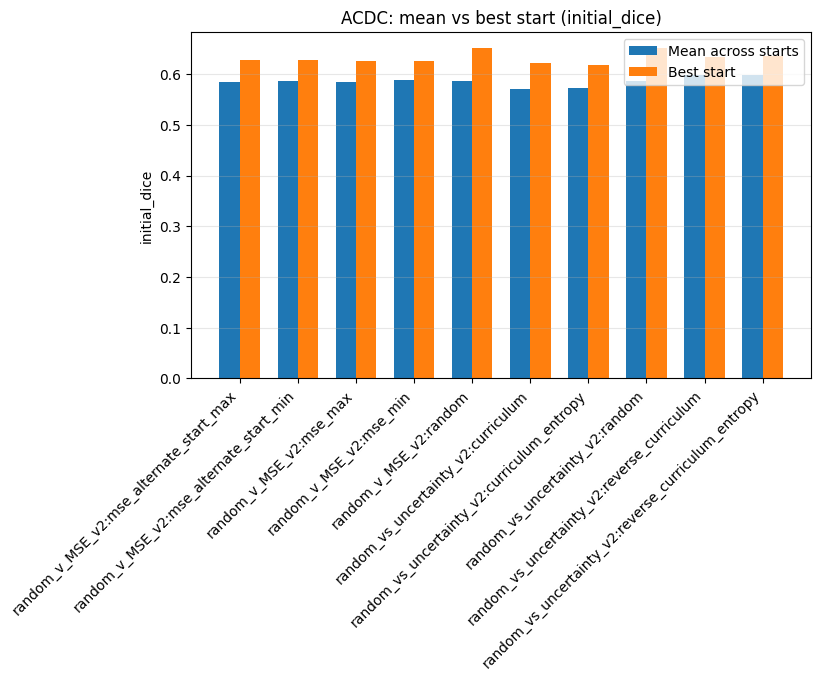

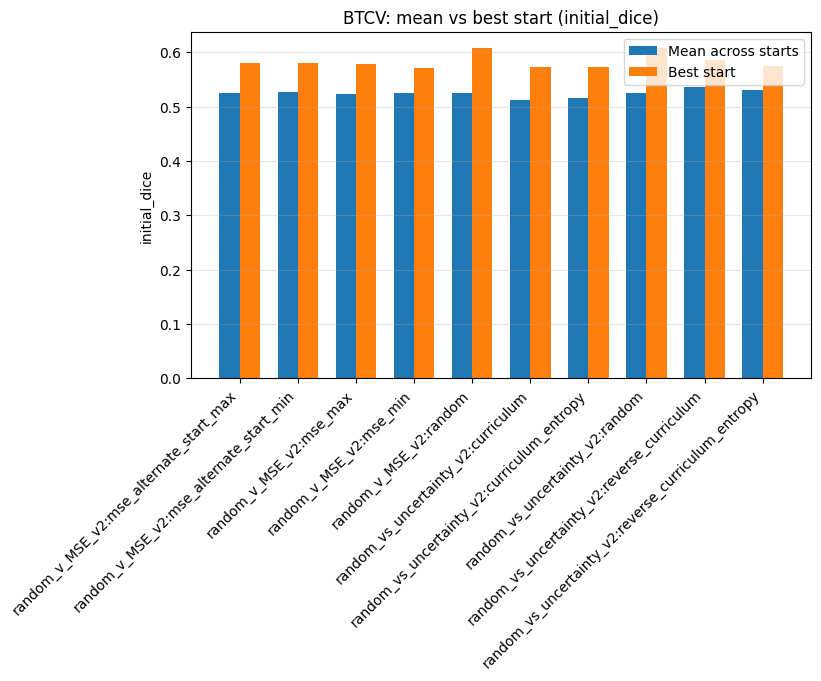

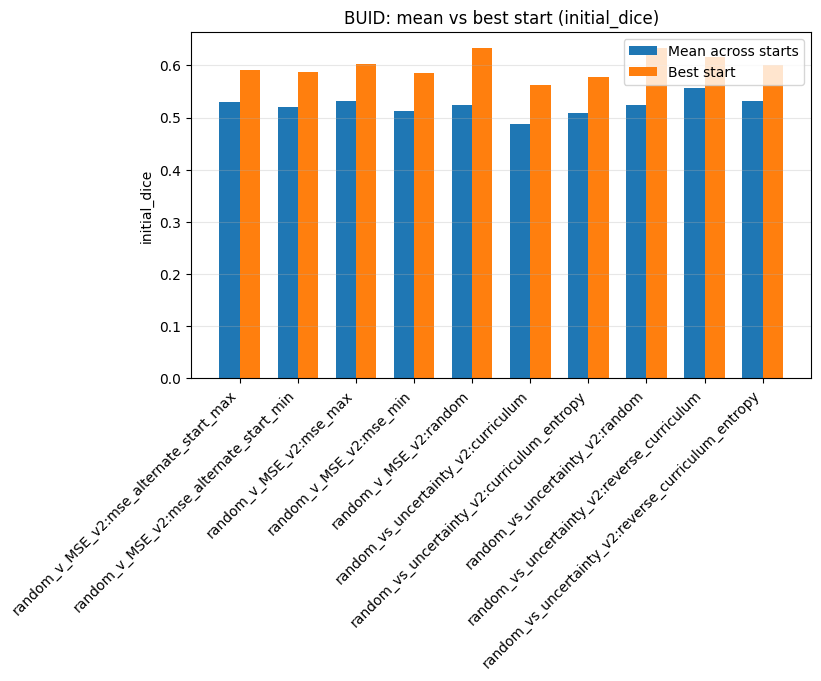

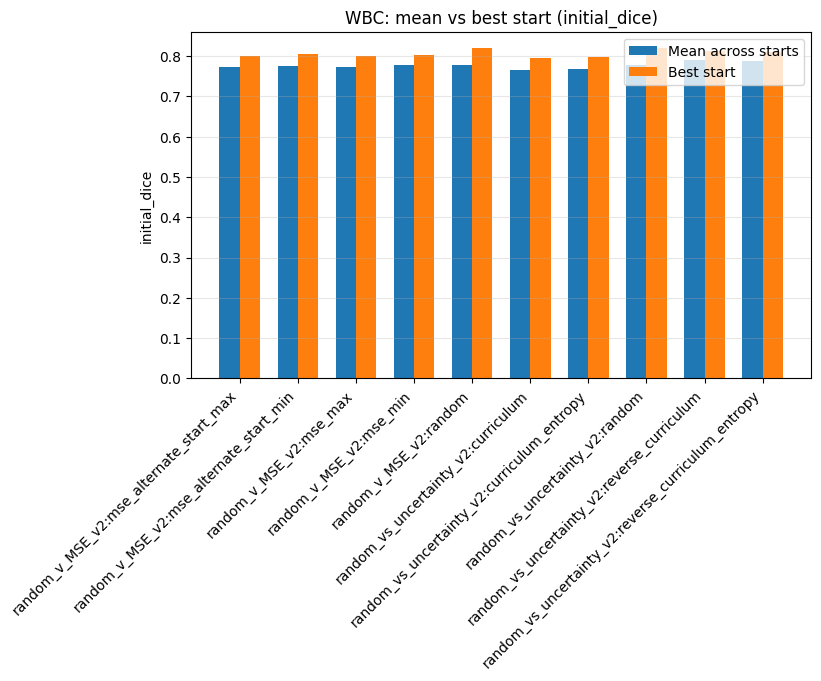

In [7]:
def plot_family(summary_df, family, metric):
    sub = summary_df[summary_df['family'] == family].copy()
    if sub.empty:
        print(f'No data for {family}')
        return
    sub = sub.sort_values(['procedure', 'policy'])
    labels = sub['procedure'] + ':' + sub['policy']
    x = np.arange(len(sub))
    width = 0.35

    fig, ax = plt.subplots(figsize=(max(8, len(sub) * 0.5), 4.5))
    ax.bar(x - width, sub['worst_start'], width, label='Worst start')
    ax.bar(x, sub['mean_start'], width, label='Mean across starts')
    ax.bar(x + width, sub['best_start'], width, label='Best start')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_ylabel(metric)
    ax.set_title(f'{family}: mean vs best start ({metric})')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.show()

# Example: plot one family
for fam in summary['family'].unique():
    plot_family(summary, fam, METRIC)
